In [2]:
import torch
import os
import cv2
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque

In [3]:
def load_cards_from_folder(folder_path):
    """
    Load all card images from a specific folder.
    
    Args:
        folder_path: Path to directory containing card images
        
    Returns:
        list: List of loaded and preprocessed card images
    """
    cards = []
    
    if not os.path.exists(folder_path):
        print(f"Error: Folder {folder_path} does not exist")
        return cards
    
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(folder_path, file_name)
            card_img = cv2.imread(image_path)
            
            if card_img is not None:
                # Preprocess the card image
                gray_card = cv2.cvtColor(card_img, cv2.COLOR_BGR2GRAY)
                gray_card = cv2.resize(gray_card, (800, 800))
                cards.append(gray_card)
            else:
                print(f"Error reading {image_path}")
    
    return cards

In [4]:
# we want to give two images, one of the player and one of the dealers.
# this should show our cards and the dealers which will be extracted
def extract_cards(player_folder, dealer_folder):
    """
    Extract cards from player and dealer image folders for a blackjack game.
    
    Args:
        player_folder: Path to folder containing player card images
        dealer_folder: Path to folder containing dealer card images
        
    Returns:
        tuple: (player_cards, dealer_cards) where each is a list of card images
    """
    # Get player cards
    player_cards = load_cards_from_folder(player_folder)
    
    # Get dealer cards
    dealer_cards = load_cards_from_folder(dealer_folder)
    
    return player_cards, dealer_cards


In [5]:
def gaussian_kernel(size, sigma):
    """ Implementation of Gaussian Kernel.

    This function follows the gaussian kernel formula,
    and creates a kernel matrix.

    Hints:
    - Use np.pi and np.exp to compute pi and exp.

    Args:
        size: int of the size of output matrix.
        sigma: float of sigma to calculate kernel.

    Returns:
        kernel: numpy array of shape (size, size).
    """

    kernel = np.zeros((size, size))

    ### YOUR CODE HERE
    for i in range(size):
      for j in range(size):
        k = (size - 1) // 2
        base = 1 / ((2 * np.pi * (sigma ** 2)))
        exp = ((((i - k) ** 2) + ((j - k) ** 2)) / (2 * (sigma ** 2)))

        kernel[i][j] = (base * (np.exp(-exp)))
    ### END YOUR CODE
    return kernel

In [6]:
def conv(image, kernel):
    """ An implementation of convolution filter.

    This function uses element-wise multiplication and np.sum()
    to efficiently compute weighted sum of neighborhood at each
    pixel.

    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).

    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    # For this assignment, we will use edge values to pad the images.
    # Zero padding will make derivatives at the image boundary very big,
    # whereas we want to ignore the edges at the boundary.
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    ### YOUR CODE HERE
    flipped_kernel = np.flip(kernel)
    for i in range(Hi):
      for j in range(Wi):
        height_bound = i + Hk
        width_bound = j + Wk

        cur_area = padded[i:height_bound, j:width_bound]
        out[i][j] = np.sum(cur_area * flipped_kernel)
    ### END YOUR CODE

    return out

In [7]:
def partial_x(img):
    """ Computes partial x-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.

    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: x-derivative image.
    """

    out = None

    ### YOUR CODE HERE
    kernel = np.array([[-0.5, 0, 0.5]])
    flipped_kernel = np.flip(kernel)
    out = conv(img, flipped_kernel)
    ### END YOUR CODE

    return out

In [8]:

def partial_y(img):
    """ Computes partial y-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.

    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: y-derivative image.
    """

    out = None

    ## YOUR CODE HERE
    kernel = np.array([[-0.5], [0], [0.5]])
    flipped_kernel = np.flip(kernel)
    out = conv(img, flipped_kernel)
    ### END YOUR CODE

    return out

In [9]:

def gradient(img):
    """ Returns gradient magnitude and direction of input img.

    Args:
        img: Grayscale image. Numpy array of shape (H, W).

    Returns:
        G: Magnitude of gradient at each pixel in img.
            Numpy array of shape (H, W).
        theta: Direction(in degrees, 0 <= theta < 360) of gradient
            at each pixel in img. Numpy array of shape (H, W).

    Hints:
        - Use np.sqrt and np.arctan2 to calculate square root and arctan
    """
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    ### YOUR CODE HERE
    Gx = partial_x(img)
    Gy = partial_y(img)

    G = np.sqrt(((Gx ** 2) + (Gy ** 2)))
    theta = (np.arctan2(Gy, Gx) * (180 / np.pi))
    theta %= 360
    ### END YOUR CODE

    return G, theta

In [10]:
def non_maximum_suppression(G, theta):
    """ Performs non-maximum suppression.

    This function performs non-maximum suppression along the direction
    of gradient (theta) on the gradient magnitude image (G).

    Args:
        G: gradient magnitude image with shape of (H, W).
        theta: direction of gradients with shape of (H, W).

    Returns:
        out: non-maxima suppressed image.
    """
    H, W = G.shape
    out = np.zeros((H, W))

    # Round the gradient direction to the nearest 45 degrees
    theta = np.floor((theta + 22.5) / 45) * 45

    #print(G)
    ### BEGIN YOUR CODE
    theta %= 180
    G_padded = np.pad(G, pad_width=1, mode='constant', constant_values=0)

    for i in range(H):
      for j in range(W):
        i_pad, j_pad = i + 1, j + 1

        if theta[i][j] == 0:
          j_e = j_pad + 1
          j_w = j_pad - 1

          e_val = G_padded[i_pad][j_e]
          w_val = G_padded[i_pad][j_w]

          if e_val > G[i][j] or w_val > G[i][j]:
            out[i][j] = 0
          else:
            out[i][j] = G[i][j]

        elif theta[i][j] == 135:
          i_ne = i_pad - 1
          j_ne = j_pad + 1

          i_sw = i_pad + 1
          j_sw = j_pad - 1

          ne_val = G_padded[i_ne][j_ne]
          sw_val = G_padded[i_sw][j_sw]

          if ne_val > G[i][j] or sw_val > G[i][j]:
             out[i][j] = 0
          else:
            out[i][j] = G[i][j]

        elif theta[i][j] == 90:
          i_n = i_pad - 1
          i_s = i_pad + 1

          n_val = G_padded[i_n][j_pad]
          s_val = G_padded[i_s][j_pad]

          if n_val > G[i][j] or s_val > G[i][j]:
             out[i][j] = 0
          else:
            out[i][j] = G[i][j]

        elif theta[i][j] == 45:
          i_nw = i_pad - 1
          j_nw = j_pad - 1

          i_se = i_pad + 1
          j_se = j_pad + 1

          nw_val = G_padded[i_nw][j_nw]
          se_val = G_padded[i_se][j_se]

          if nw_val > G[i][j] or se_val > G[i][j]:
             out[i][j] = 0
          else:
            out[i][j] = G[i][j]

    ### END YOUR CODE

    return out

In [11]:
def double_thresholding(img, high, low):
  """
  Args:
      img: numpy array of shape (H, W) representing NMS edge response.
      high: high threshold(float) for strong edges.
      low: low threshold(float) for weak edges.

  Returns:
      strong_edges: Boolean array representing strong edges.
          Strong edeges are the pixels with the values greater than
          the higher threshold.
      weak_edges: Boolean array representing weak edges.
          Weak edges are the pixels with the values smaller or equal to the
          higher threshold and greater than the lower threshold.
  """

  strong_edges = np.zeros(img.shape, dtype=bool)
  weak_edges = np.zeros(img.shape, dtype=bool)

  ### YOUR CODE HERE
  H, W = np.shape(img)

  for i in range(H):
    for j in range(W):
      if img[i, j] > high:
        strong_edges[i, j] = True
      elif img[i, j] < low:
        weak_edges[i, j] = True
      else:
        strong_edges[i, j] = False
        weak_edges[i, j] = False

  ### END YOUR CODE

  return strong_edges, weak_edges

In [12]:
def get_neighbors(y, x, H, W):
    """ Return indices of valid neighbors of (y, x).

    Return indices of all the valid neighbors of (y, x) in an array of
    shape (H, W). An index (i, j) of a valid neighbor should satisfy
    the following:
        1. i >= 0 and i < H
        2. j >= 0 and j < W
        3. (i, j) != (y, x)

    Args:
        y, x: location of the pixel.
        H, W: size of the image.
    Returns:
        neighbors: list of indices of neighboring pixels [(i, j)].
    """
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors

In [13]:
def link_edges(strong_edges, weak_edges):
    """ Find weak edges connected to strong edges and link them.

    Iterate over each pixel in strong_edges and perform breadth first
    search across the connected pixels in weak_edges to link them.
    Here we consider a pixel (a, b) is connected to a pixel (c, d)
    if (a, b) is one of the eight neighboring pixels of (c, d).

    Args:
        strong_edges: binary image of shape (H, W).
        weak_edges: binary image of shape (H, W).

    Returns:
        edges: numpy boolean array of shape(H, W).
    """

    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=bool)

    # Make new instances of arguments to leave the original
    # references intact
    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    ### YOUR CODE HERE
    queue = deque([])
    visit = set()

    for x, y in indices:
      queue.append((x, y))
      visit.add((x, y))

    while queue:
      x, y = queue.popleft()
      neighbors = get_neighbors(x, y, H, W)

      for i, j in neighbors:
        if not weak_edges[i, j] and (i, j) not in visit:
          queue.append((i, j))
          edges[i, j] = True
          visit.add((i, j))


    ### END YOUR CODE
    return edges

In [14]:
def canny(img, kernel_size=5, sigma=1.4, high=25, low=20):
    """ Implement canny edge detector by calling functions above.

    Args:
        img: binary image of shape (H, W).
        kernel_size: int of size for kernel matrix.
        sigma: float for calculating kernel.
        high: high threshold for strong edges.
        low: low threashold for weak edges.
    Returns:
        edge: numpy array of shape(H, W).
    """
    ### YOUR CODE HERE
    kernel = gaussian_kernel(kernel_size, sigma)

    filter = conv(img, kernel)

    G, theta = gradient(filter)
    nms_image = non_maximum_suppression(G, theta)

    strong_edges, weak_edges = double_thresholding(nms_image, high, low)

    edge = link_edges(strong_edges, weak_edges)
    ### END YOUR CODE

    return edge

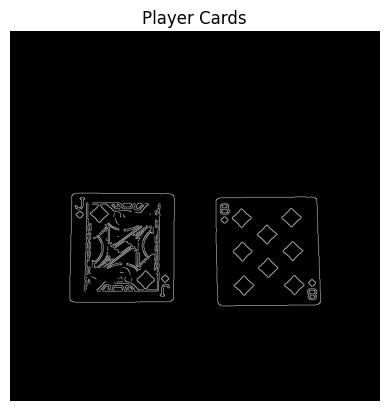

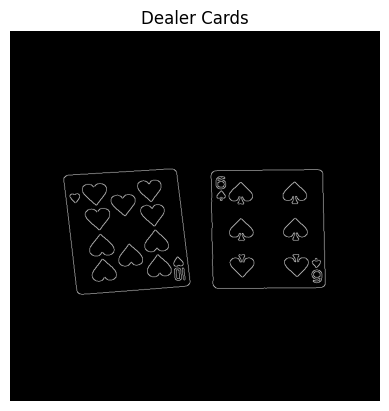

In [15]:
player_cards, dealer_cards = extract_cards("player_cards", "dealer_cards")

canny_results = []

for gray in player_cards:
    canny_result = canny(gray)
    canny_results.append(canny_result)
    plt.imshow(canny_result, cmap='gray')
    plt.axis('off')  
    plt.title('Player Cards')
    plt.show()

for gray in dealer_cards:
    canny_result = canny(gray)
    canny_results.append(canny_result)
    plt.imshow(canny_result, cmap='gray')
    plt.axis('off')  
    plt.title('Dealer Cards')
    plt.show()

In [39]:
def predict_card(image_path, model_path, display_probabilities=True):
    # Define the mappings (reverse of what you used for training)
    rank_map = {0: 'A', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7',
               7: '8', 8: '9', 9: '10', 10: 'J', 11: 'Q', 12: 'K'}
    suit_map = {0: 'Clubs', 1: 'Diamonds', 2: 'Hearts', 3: 'Spades'}
    
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  
    
    # Display the processed image
    if display_probabilities:
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title("Processed Image (224x224)")
        plt.axis('off')
        plt.show()
    
    # Apply the same transformations as during training
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    
    # Load the model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Create model instance (same architecture as during training)
    class CardClassifier(nn.Module):
        def __init__(self):
            super(CardClassifier, self).__init__()
            # First block
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(32)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            
            # Second block
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(64)
            self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
            self.bn4 = nn.BatchNorm2d(64)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            
            # Third block
            self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn5 = nn.BatchNorm2d(128)
            self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
            self.bn6 = nn.BatchNorm2d(128)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            
            # Calculate flattened size (for 224x224 input)
            self.flat_features = 128 * 28 * 28
            
            # Fully connected layers
            self.fc1 = nn.Linear(self.flat_features, 512)
            self.fc_bn1 = nn.BatchNorm1d(512)
            self.fc2 = nn.Linear(512, 256)
            self.fc_bn2 = nn.BatchNorm1d(256)
            
            # Output layers
            self.rank_classifier = nn.Linear(256, 13)
            self.suit_classifier = nn.Linear(256, 4)
            
            self.dropout = nn.Dropout(0.5)
        
        def forward(self, x):
            # First block
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.bn2(self.conv2(x)))
            x = self.pool1(x)
            
            # Second block
            x = F.relu(self.bn3(self.conv3(x)))  # Fixed the variable name typo
            x = F.relu(self.bn4(self.conv4(x)))
            x = self.pool2(x)
            
            # Third block
            x = F.relu(self.bn5(self.conv5(x)))
            x = F.relu(self.bn6(self.conv6(x)))
            x = self.pool3(x)
            
            # Flatten
            x = torch.flatten(x, 1)
            
            # Fully connected layers
            x = F.relu(self.fc_bn1(self.fc1(x)))
            x = self.dropout(x)
            x = F.relu(self.fc_bn2(self.fc2(x)))
            x = self.dropout(x)
            
            # Output layers
            rank_output = self.rank_classifier(x)
            suit_output = self.suit_classifier(x)
            
            return rank_output, suit_output
    
    model = CardClassifier().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        img_tensor = img_tensor.float().to(device)
        rank_outputs, suit_outputs = model(img_tensor)
        
        # Get probabilities
        rank_probs = F.softmax(rank_outputs, dim=1)
        suit_probs = F.softmax(suit_outputs, dim=1)
        
        # if display_probabilities:
        #     # Show all rank probabilities
        #     plt.figure(figsize=(12, 5))
        #     plt.subplot(1, 2, 1)
        #     plt.bar(list(rank_map.values()), rank_probs[0].cpu().numpy()[:len(rank_map)])
        #     plt.title("Rank Probabilities")
        #     plt.ylabel("Probability")
        #     plt.xlabel("Rank")
            
        #     # Show all suit probabilities
        #     plt.subplot(1, 2, 2)
        #     plt.bar(list(suit_map.values()), suit_probs[0].cpu().numpy()[:len(suit_map)])
        #     plt.title("Suit Probabilities")
        #     plt.ylabel("Probability")
        #     plt.xlabel("Suit")
            
        #     plt.tight_layout()
        #     plt.show()
        
        # Get predicted classes
        _, rank_pred = torch.max(rank_probs, 1)
        _, suit_pred = torch.max(suit_probs, 1)
        
        rank_idx = rank_pred.item()
        suit_idx = suit_pred.item()
        
        rank_label = rank_map[rank_idx]
        suit_label = suit_map[suit_idx]
        
        # Get confidence scores
        rank_confidence = rank_probs[0][rank_pred].item() * 100
        suit_confidence = suit_probs[0][suit_pred].item() * 100
        
        # Print top 3 rank predictions
        top3_ranks_values, top3_ranks_indices = torch.topk(rank_probs[0], 3)
        print("Top 3 rank predictions:")
        for i in range(3):
            idx = top3_ranks_indices[i].item()
            if idx < len(rank_map):
                print(f"{rank_map[idx]}: {top3_ranks_values[i].item()*100:.2f}%")
            
        # Print top 3 suit predictions
        top3_suits_values, top3_suits_indices = torch.topk(suit_probs[0], 3)
        print("\nTop 3 suit predictions:")
        for i in range(3):
            idx = top3_suits_indices[i].item()
            if idx < len(suit_map):
                print(f"{suit_map[idx]}: {top3_suits_values[i].item()*100:.2f}%")
    
    # Handle joker output
    card_name = f"{rank_label} of {suit_label}"
    
    result = {
        'card': card_name,
        'rank': rank_label,
        'suit': suit_label,
        'rank_confidence': rank_confidence,
        'suit_confidence': suit_confidence,
        'rank_probs': {rank_map[i]: prob.item() for i, prob in enumerate(rank_probs[0]) if i in rank_map},
        'suit_probs': {suit_map[i]: prob.item() for i, prob in enumerate(suit_probs[0]) if i in suit_map}
    }
    
    return result

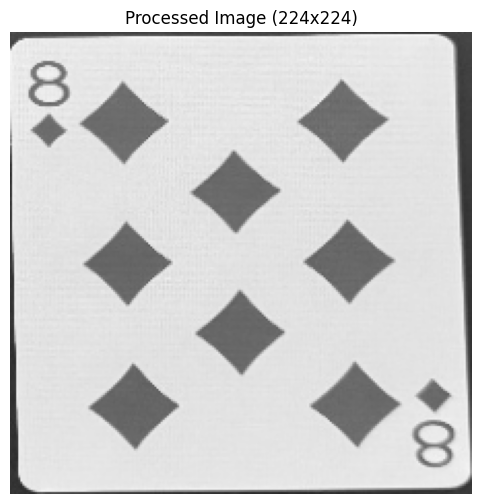

Top 3 rank predictions:
8: 100.00%
10: 0.00%
6: 0.00%

Top 3 suit predictions:
Diamonds: 100.00%
Spades: 0.00%
Hearts: 0.00%


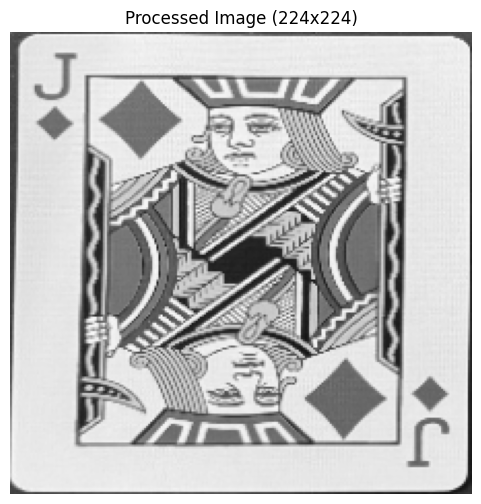

Top 3 rank predictions:
J: 99.99%
K: 0.01%
5: 0.00%

Top 3 suit predictions:
Diamonds: 99.89%
Spades: 0.10%
Hearts: 0.00%
Player's cards: ['8 of Diamonds', 'J of Diamonds']
Player's score: 18


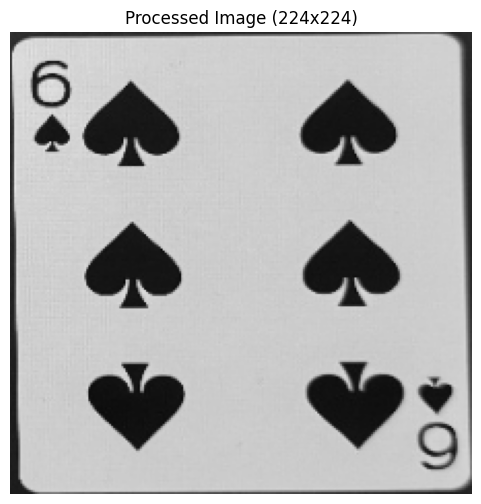

Top 3 rank predictions:
6: 100.00%
8: 0.00%
4: 0.00%

Top 3 suit predictions:
Spades: 100.00%
Clubs: 0.00%
Diamonds: 0.00%


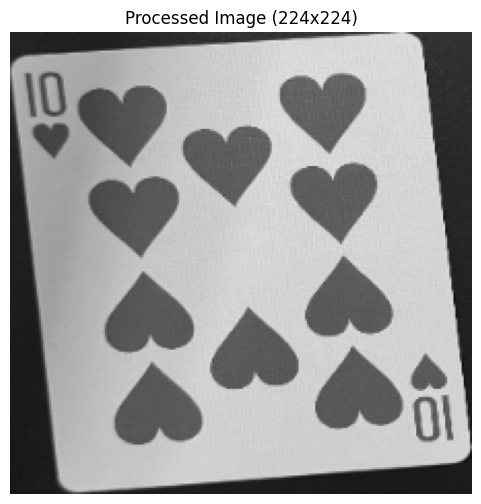

Top 3 rank predictions:
10: 99.71%
6: 0.09%
8: 0.09%

Top 3 suit predictions:
Hearts: 90.03%
Clubs: 9.92%
Diamonds: 0.03%
Dealer's cards: ['6 of Spades', '10 of Hearts']
Dealer's score: 16


In [43]:
def get_outline_and_predict(card, model_path, player_type="Player"):
    output_folder = "output_cards"
    os.makedirs(output_folder, exist_ok=True)
    
    card_results = []
    
    # Loop through each grayscale image
    for idx, gray in enumerate(card):
        # Compute the Canny edge detection result for this image
        canny_result = canny(gray)
        canny_result_uint8 = (canny_result * 255).astype(np.uint8)
        contours, hierarchy = cv2.findContours(canny_result_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Filter contours by area first
        filtered_contours = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if 10000 < area < 300000:
                filtered_contours.append(contour)
        
        # Just keep the first contour if they're duplicates (comparing only the first two)
        if len(filtered_contours) > 1:
            boxes = [cv2.boundingRect(c) for c in filtered_contours]
            x1, y1, w1, h1 = boxes[0]
            x2, y2, w2, h2 = boxes[1]
            if x1 == x2 and y1 == y2 and w1 == w2 and h1 == h2:
                print("Found duplicate contours with identical coordinates - keeping only one")
                final_contours = [filtered_contours[0]]
            else:
                final_contours = filtered_contours
        else:
            final_contours = filtered_contours
        
        # Create a color image for visualization of this gray image
        result_img = cv2.cvtColor(gray.copy(), cv2.COLOR_GRAY2BGR)
        
        # Process each final contour to extract card images
        card_images = []
        card_paths = []
        
        for i, contour in enumerate(final_contours):
            x, y, w, h = cv2.boundingRect(contour)
            card = gray[y:y+h, x:x+w]
            card_images.append(card)
            
            # Save the card image
            output_path = os.path.join(output_folder, f"{player_type.lower()}_image{idx+1}_card_{i+1}.jpg")
            cv2.imwrite(output_path, card)
            card_paths.append(output_path)
            
            # Draw green rectangle and label on the result image
            cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 3)
            cv2.putText(result_img, f"Card {i+1}", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        # Visualize the detection results for the current image
        # plt.figure(figsize=(10, 6))
        # plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        # plt.title(f"{player_type}'s Image {idx+1} - Detected Cards: {len(card_images)}")
        # plt.axis('off')
        # plt.show()
        
        # Predict each card
        for path in card_paths:
            result = predict_card(path, model_path)
            card_results.append(result)
            
    # Calculate total blackjack score
    total_score = 0
    ace_count = 0
    
    for card in card_results:
        rank = card['rank']
        if rank in ['J', 'Q', 'K']:
            total_score += 10
        elif rank == 'A':
            total_score += 11
            ace_count += 1
        else:
            try:
                total_score += int(rank)
            except:
                print(f"Could not convert rank {rank} to a number")
    
    # Adjust for aces if needed
    while total_score > 21 and ace_count > 0:
        total_score -= 10
        ace_count -= 1
    
    print(f"{player_type}'s cards: {[card['card'] for card in card_results]}")
    print(f"{player_type}'s score: {total_score}")
    
    return {
        'cards': card_results,
        'total_score': total_score
    }

# Example usage:
player_results = get_outline_and_predict(player_cards, "../models/131_100.pth", "Player")
dealer_results = get_outline_and_predict(dealer_cards, "../models/131_100.pth", "Dealer")

In [44]:
def basic_strategy(player_total, dealer_value, soft):
    """ This is a simple implementation of Blackjack's
        basic strategy. It is used to recommend actions
        for the player. """

    if 4 <= player_total <= 8:
        return 'hit'
    if player_total == 9:
        if dealer_value in [1,2,7,8,9,10]:
            return 'hit'
        return 'double'
    if player_total == 10:
        if dealer_value in [1, 10]:
            return 'hit'
        return 'double'
    if player_total == 11:
        if dealer_value == 1:
            return 'hit'
        return 'double'
    if soft:
        #we only double soft 12 because there's no splitting
        if player_total in [12, 13, 14]:
            if dealer_value in [5, 6]:
                return 'double'
            return 'hit'
        if player_total in [15, 16]:
            if dealer_value in [4, 5, 6]:
                return 'double'
            return 'hit'
        if player_total == 17:
            if dealer_value in [3, 4, 5, 6]:
                return 'double'
            return 'hit'
        if player_total == 18:
            if dealer_value in [3, 4, 5, 6]:
                return 'double'
            if dealer_value in [2, 7, 8]:
                return 'stand'
            return 'hit'
        if player_total >= 19:
            return 'stand'

    else:
        if player_total == 12:
            if dealer_value in [1, 2, 3, 7, 8, 9, 10]:
                return 'hit'
            return 'stand'
        if player_total in [13, 14, 15, 16]:
            if dealer_value in [2, 3, 4, 5, 6]:
                return 'stand'
            return 'hit'

        if player_total >= 17:
            return 'stand'


In [46]:
def blackjack(player_results, dealer_results):
    """
    Advises the player on what action to take based on their hand and the dealer's visible card.
    
    Args:
        player_results: Dictionary containing player's cards and total score
        dealer_results: Dictionary containing dealer's cards and total score
        
    Returns:
        str: Recommendation for the player (hit, stand, double)
    """
    # Get player's total score
    player_total = player_results['total_score']
    
    # Get dealer's visible card (first card)
    dealer_card = dealer_results['cards'][0]['rank']
    
    # Convert dealer's card to value
    if dealer_card in ['J', 'Q', 'K']:
        dealer_value = 10
    elif dealer_card == 'A':
        dealer_value = 1  # Basic strategy uses 1 for Ace
    else:
        dealer_value = int(dealer_card)
    
    # Check if player has a soft hand (contains an Ace counted as 11)
    soft = False
    for card in player_results['cards']:
        if card['rank'] == 'A' and player_total <= 21:
            soft = True
            break
    
    # Get recommendation from basic strategy
    recommendation = basic_strategy(player_total, dealer_value, soft)
    
    # Create detailed message for the player
    message = f"Your hand: {[card['card'] for card in player_results['cards']]}\n"
    message += f"Your total: {player_total}\n"
    message += f"Dealer's visible card: {dealer_results['cards'][0]['card']}\n"
    message += f"Recommended action: {recommendation.upper()}"
    
    # Add explanations based on the recommendation
    if recommendation == 'hit':
        message += "\n\nYou should take another card to improve your hand."
    elif recommendation == 'stand':
        message += "\n\nYou should keep your current hand."
    elif recommendation == 'double':
        message += "\n\nYou should double your bet and take exactly one more card."
        message += "\n(If doubling is not allowed, hit instead.)"
    
    return message

# Example usage:
print(blackjack(player_results, dealer_results))

Your hand: ['8 of Diamonds', 'J of Diamonds']
Your total: 18
Dealer's visible card: 6 of Spades
Recommended action: STAND

You should keep your current hand.
